# Forward Operators

In computational imaging, the ability to model the acquisition system accurately is a cornerstone for solving inverse problems. The `LinOp` class in Pyxu serves as a foundational abstraction for defining linear forward operators, essentially mapping the original signal or image to the data we observe. This guide is designed to equip you with the knowledge needed to implement custom forward operators using the `LinOp` class, as well as related classes in the Pyxu library.

> **Note**: The `LinOp` class and others discussed here are abstract classes. They are not intended to be instantiated directly but should be subclassed to suit your specific needs. Alternatively, you can use the generic constructor routine `from_source` to define new operators based on their core methods.

## The Importance of Matrix-Free Operators 🎯

Computational imaging often involves working with (very) large data sets, which poses challenges in terms of scalability.  In Pyxu, the strategy for addressing such challenges is to employ **matrix-free operators**. These operators are defined implicitly via methods rather than explicitly through matrices. This strategy saves memory and improves computational efficiency.

For example, the following code snippet implements a matrix-free sum operator operating over 1D inputs:

```python
class Sum(LinOp):
    def apply(self, arr):
        return arr.sum()
    
    def adjoint(self, arr):
        return arr * np.ones(self.shape[1])
```

This code snippet demonstrates how to define a simple matrix-free linear operator that computes the sum of elements in an array. Let's break down the components:

- **Class Definition:**
    ```python
    class Sum(LinOp):
    ```
    Here, a new class called `Sum` is defined, inheriting from Pyxu's `LinOp` base class, the primary abstraction for designing real-valued linear forward operators. This inheritance means that Sum is expected to implement certain core methods, namely `apply` and `adjoint`. 


- **The `apply` Method:**
    ```python
        def apply(self, arr):
            return arr.sum()
    ```
    The `apply` method takes an array `arr` as input and returns the sum of its elements. This is the core functionality of the operator. Instead of representing the sum operation as a matrix and performing matrix-vector multiplication, the method directly computes the sum, making it "matrix-free."

- **The `adjoint` Method:**
    ```python
        def adjoint(self, arr):
            return arr * np.ones(self.shape[1])
    ```
    The `adjoint` method also takes an array `arr` as input. The adjoint operation for this sum operator is effectively a "broadcast" operation, mapping a scalar to a vector with the same dimension of the original array space.


## Demistifying the Adjoint 🧩

The concept of an "adjoint" operator can initially be a bit elusive, so let's use some intuition to understand it. When we talk about a forward operator in computational imaging or signal processing, we're usually describing a transformation that takes an input (often some form of data or signal) and produces an output (often some form of measurement or transformed data).

Now, what if you wanted to go in the opposite direction? What if you had a blurry image and wanted to reconstruct the original, clear image? This "reverse" operation is what the adjoint operator aims to approximate.

In mathematical terms, the adjoint operator is formally defined to be the dual of the forward operator with respect to a particular inner product space. It's often considered as a kind of "inverse" to the forward operator. However, it's important to note that it's not necessarily the true inverse; rather, you can think of it as a linear approximation to reverse the forward operator's action.

In computational imaging and inverse problems, the adjoint operator is frequently used in iterative algorithms to reconstruct the original data from measurements. The forward operator models the measurement process, and the adjoint helps in the reconstruction process.

So, when you see the term "adjoint," you can think of it as the backward counterpart to your forward operator, designed to undo or approximate the undoing of whatever your forward operator did. 

Computing the adjoint of a complex forward operator can be a challenging task, especially in fields like tomography where even well-established implementations can have mismatched adjoints for the Radon transform. The mismatch often arises due to approximations or discretizations that make the adjoint non-trivial to compute directly.

### Divide and Conquer Strategy

A useful approach to tackle this issue is to divide and conquer: break down the complex operator into a chain of simpler, well-understood operators for which the adjoints are known or easily computed. Once you have this chain, you can leverage the properties of adjoint operators to calculate the adjoint of the entire composition. Mathematically, if you have operators $A$ and $B$, the adjoint of $AB$ is $B^* A^*$, where $^*$ denotes the adjoint.

Pyxu excels in this context, thanks to its operator algebra logic. It allows you to compose operators easily, and when you ask for the adjoint, Pyxu will automatically compute it for you by leveraging the adjoint properties and the chain of simpler operators you've defined. In effect, Pyxu performs the heavy lifting, letting you focus on defining the core aspects of your operators.

So, instead of getting bogged down with the mathematical intricacies of calculating a complex adjoint operator, you can use Pyxu to implement your forward operator as a chain of simpler ones. Pyxu takes care of the rest, giving you a powerful, yet computationally efficient, way to tackle challenging problems in computational imaging. Divide and conquer! 🛠️🔍

### Quality Assurance for Adjoint Operators in Pyxu

Pyxu goes the extra mile to ensure the accuracy and integrity of the adjoint operators within its library. Our comprehensive test suite rigorously validates the correctness of adjoint implementations for every operator. This gives you the confidence that you are indeed working with mathematically valid adjoints, offering you a robust foundation for your computational imaging projects. 🛡️🔍

## Additional Features of `LinOp`: Batteries Included 🌟🔋

Pyxu's `LinOp` is designed to be as versatile and useful as possible for computational imaging. Here are some of the extra capabilities baked right into the class to facilitate both simple and complex tasks:

- **Lipschitz Constant**: Knowing the Lipschitz constant of an operator is invaluable for optimization routines. If you know it, you can directly store it in the `lipschitz` property. Don't know it? No problem! The `estimate_lipschitz()` method will compute it for you, offering various methods to balance accuracy and execution time.

```python
my_operator.lipschitz = my_operator.estimate_lipschitz()
```

- **Singular Value Decomposition**: Ever needed to compute the singular values of your operator? Use the `svdvals()` method which employs the Arnoldi method to get the job done without breaking the matrix-free paradigm.

- **Trace of Operator**: Sometimes you may need to compute the trace of an operator. The `trace()` method uses a stochastic approximation with the Hutch++ algorithm to efficiently estimate the trace.

- **Pseudo-Inverse**: If you're looking to solve an inverse problem, the `pinv()` method helps you evaluate the pseudo-inverse by solving the (dampened) normal equations, making it the most straightforward way to reverse your operations.

```python
pseudo_inv_result = my_operator.pinv(my_array, damp=value)
```

- **Support for Explicit Matrices**: Though `LinOp` is primarily built for matrix-free operations, you are not restricted to them. If you prefer, you can work with explicit matrices using the `from_array()` method, supporting a variety of array formats including `numpy`, `cupy`, `sparse`, and `dask`.

```python
op = LinOp.from_array(np.ones((N, N)))
```

With all these tools and methods at your disposal, `LinOp` aims to be your go-to solution for implementing linear operators in computational imaging tasks.

## `DiffMap` for Non-linear Forward Operators 🌈

Linear models are often an idealized representation, and in some situations, the forward operators are inherently non-linear. Take phase retrieval or some forms of tomography as examples; these are scenarios where the relationship between the object and its measurements isn't just a linear transformation. For such cases, Pyxu provides the `DiffMap` class to implement these non-linear forward operators.

### Core Methods 🛠️

- **`apply`**: This method is where you'll implement your forward model. Just like in `LinOp`, you override this function to define how your specific forward model operates on an input array.

- **`jacobian`**: In calculus, the Jacobian matrix represents the best linear approximation to a function at a given point. For a function $\mathbf{f}: \mathbb{R}^{M} \to \mathbb{R}^{N}$, the Jacobian $\mathbf{J}_{\mathbf{f}}(\mathbf{x})$ at a point $\mathbf{x}$ is an $N \times M$ matrix where the entry $(i, j)$ is $\frac{\partial f_{i}}{\partial x_{j}}$. When the forward operator is non-linear, knowing the Jacobian is crucial for optimization algorithms.

The `jacobian()` method allows you to evaluate this matrix, giving you the flexibility to implement the best way to approximate your non-linear operator linearly at a specific point.

### A Nod to Deep Learning 🚀

When the Jacobian is unknown or too complex to derive analytically, techniques from deep learning come in handy. Libraries like JAX or PyTorch offer automatic differentiation techniques (autograd) to compute derivatives, which you can use to obtain the Jacobian efficiently in a matrix-free fashion.

In Pyxu, methods `from_torch` and `from_jax` allow you to define operators whose Jacobians are computed via autograd. This means you can utilize the power of these deep learning libraries to implement non-linear operators seamlessly.

With `DiffMap`, you're well-equipped to tackle the challenges posed by non-linear forward operators in computational imaging.

## Wrapping Up 🎁

Pyxu offers a robust and scalable framework for computational imaging professionals dealing with both linear and non-linear forward operators. With the abstraction provided by classes like `LinOp` and `DiffMap`, you can focus on the problem you're solving rather than the computational limitations. These classes are meant to be subclassed to tailor to your specific problem domain. Happy coding! 🚀


## Operator Algebra Logic

Complex operators can be constructed by composing Pycsou's fundamental building blocks via the following set of arithmetic operations:

```python
>> op1 + op2 # Addition of two operators
>> op1 * op2 # Composition of two operators
>> op ** 3   # Exponentiation of an operator
>> op.argscale(c), op.argshift(x) # Dilation/shifting
>> 4 * op # Scaling
```
In each case, the type of the output is automatically determined from the set of properties of both operators preserved by the arithmetic operation with all methods inferred from those of the operands. 

In particular, the methods``apply()``, ``jacobian()``, ``grad()``, ``prox()``, ``adjoint()`` are updated via chain rules, allowing users to use the composite operators in proximal gradient algorithms without having to worry about implementing gradients/proximal steps.

For example, composing a ``DiffFunc`` with a ``DiffMap`` results in a ``DiffFunc`` with ``grad()`` given by: 

```python
>> h = f * L
>> h.grad(x) = L.jacobian(x).adjoint(f.grad(L(x)))
```

It is also possible to define block-operators via ``coo_block`` (or higher-level functions ``block``, ``block_diag``, ``stack`` ``vstack``, ``hstack``):
```python
>> coo_block(([A(500,1000), B(1,1000), C(500,500), D(1,3)],  # data
   ...      [[0, 1, 0, 2],  # i
   ...       [0, 0, 2, 1],  # j
            ]),grid_shape=(3, 3))
```

| coarse_idx |      0       |    1    |      2      |
|------------|--------------|---------|-------------|
|          0 | A(500, 1000) |         | C(500, 500) |
|          1 | B(1, 1000)   |         |             |
|          2 |              | D(1, 3) |             |

For example, the following functional: 

$$ h(x) = \sum_{i=1}^3 f_i(K_ix)$$

can be easily be constructed from block operations via:

```python
f = hstack([f_1, f_2, f_3]) * vstack([K_1, K_2, K_3])
```
Again, the output type and methods/attributes of the block-operator are inferred automatically from those of the blocks.

## Lipschitz constants

Pycsou operators all come with (not necessarily tight) Lipschitz/diff-Lipschitz constants which can be accessed via the methods ``lipschitz()`` and ``diff_lipschitz()`` respectively. This is useful for automatically choosing suitable step sizes in optimisation algorithms (done under the hood by Pycsou's algorithmic suite). 


For user-defined operators with unknown Lipschitz constant, calling ``lipschitz()`` for the first time will compute the Frobenius norm of the operator and use it as a rough Lipschitz constant (cached for subsequent calls):

$$ \|A\|_2\leq \|A\|_F=\text{trace}(AA^\ast)=\text{trace}(A^\ast A)\leq \sqrt{\min(N,M)} \|A\|_2$$

This Lipschitz constant is generally not tight (tight for flat spectra), but very cheap to compute (we use the *Hutch++ stochastic algorithm* under the hood). 



### Lipschitz constants and Operator Algebra

Whenever possible, Lipschitz constants are propagated automatically by the operator algebra logic, e.g.:

```python
>> op = diffmap * linop;  
>> op.lipschitz() = diffmap.diff_lipschitz() * (linop.lipschitz() ** 2)
```

The resulting Lipschitz constants may however not be very tight. 

For linear operators, it is possible to obtain tighter Lipschitz constants via``lipschitz(tight=True, **kwargs)``. The computation of the Lipschitz constant is then performed via a matrix-free *Arnoldi method* (namely ``scipy.linalg.svdvals()``). 

In [3]:
from pycsou.abc.operator import LinOp
import dask.array as da

rand_op = LinOp.from_array(da.random.random((10000, 10000)))
rand_op.mat 

dask.array<random_sample, shape=(10000, 10000), dtype=float64, chunksize=(4096, 4096), chunktype=numpy.ndarray>

In [4]:
rand_op.lipschitz()

5773.982484304006

In [ ]:
rand_op.lipschitz(tight=True, tol=1e-2)

## Algorithmic Suite

Most first-order state-of-the-art proximal algorithms are available in Pycsou. This includes notably:

* The **Conjugate Gradient (CG)** method (and its non-linear variant, allowing to solve problems of the form:
  $$ \min_{x\in\mathbb{R}^{N}} \frac{1}{2} \mathbf{x}^{T} \mathbf{A} \mathbf{x} - \mathbf{x}^{T} \mathbf{b}.$$
* *Accelerated* or *adaptive* **forward-backward solvers** (e.g., *Proximal Gradient* descent, *prox-ADAM*), allowing to solve problems of the form: 
$${\min_{\mathbf{x}\in\mathbb{R}^N} \;\mathcal{F}(\mathbf{x})\;\;+\;\;\mathcal{G}(\mathbf{x})}.$$
* (Overrelaxed) **primal-dual splitting methods** (e.g., *Condat-Vu, PD3O, ADMM, Chambolle-Pock, Loris-Verhoeven, Douglas-Rachford, Davis-Yin*), allowing to solve problems of the form: 
$${\min_{\mathbf{x}\in\mathbb{R}^N} \;\mathcal{F}(\mathbf{x})\;\;+\;\;\mathcal{G}(\mathbf{x})\;\;+\;\;\mathcal{H}(K\mathbf{x})}.$$

Note that, although implemented for three-term objective functionals, PDS methods can be generalized to objective functionals of the form:
$${\min_{\mathbf{x}\in\mathbb{R}^N} \;\mathcal{F}(\mathbf{x})\;\;+\;\;\mathcal{G}(\mathbf{x})\;\;+\;\;\sum_{i=1}^J\mathcal{H}_i(K_i\mathbf{x})}$$
by means of stacking operators:

```python
>> K = vstack([K_1, ..., K_J])
>> H = hstack([h_1, ..., h_J])
```


All these algorithms offer a plug-and-play experience to the user, with various pre-implemented automatic hyperparameter tuning strategies. For example, primal-dual splitting methods accept three strategies:

1. ``tuning_strategy == 1``: **safe step sizes and no relaxation**.This is the most standard way of setting the     parameters in the literature, does not leverage relaxation.
2. ``tuning_strategy == 2``: **large step sizes and no relaxation**. This strategy favours large step sizes forbidding the use of overrelaxation. 
3. ``tuning_strategy == 3``: **safe step sizes and large overrelaxation**. This strategy chooses smaller step sizes, but performs overrelaxation.


A guru interface for power-users requiring additional control is also available. The latter accepts notably overloading default stopping criteria, e.g. user-defined or obtained by composing  built-in criteria.

```python
# Stopping criterion
custom_stop_crit = (RelError(eps=1e-3, var="x", f=None, norm=2, satisfy_all=True) &
                     RelError(eps=1e-3, var="z", f=None, norm=2, satisfy_all=True) &
                     MaxIter(20)) | MaxIter(1000)
```

```python
# Initialize solver (Condat-Vu primal-dual splitting algorithm in this case)
solver = CondatVu(f=loss, g=range_constraint, h=l21_norm, K=jacobian,
                  show_progress=False, verbosity=100)
```

```python
# Fit  
solver.fit(x0=x0, tuning_strategy=2, stop_crit=custom_stop_crit)
sol = solver.solution().squeeze()
```



## High Performance Computing Features

To achieve **excellent performance and scalability**, Pycsou leverages at its core a number of *high-performance computing (HPC)* tools from the PyData stack:
* Pycsou offers a convenient **precision context manager** for changing locally the compute precision.
* Compute-critical components of the framework are **just-in-time compiled** by ``Numba``.
* Pycsou's operators are all **vectorised** and can process efficiently *stacks of inputs at once*. 
* Pycsou's code base is **module-agnostic**: a zero-copy dispatch mechanism redirects routine calls to NumPy, CuPy, Dask (or any NumPy-compliant library) based on the type of array being processed. 

> **Native support for hardware acceleration and distributed computing with a single, easy to maintain, test and read Python codebase!**

As an example, consider the following code snippet, defining the median operator:


In [5]:
from pycsou.abc import Map
from pycsou.util import get_array_module
from pycsou.runtime import enforce_precision


class Median(Map):
    def __init__(self):
        super(Median, self).__init__(shape=(1, None))

    # Enforce input/output precision.
    @enforce_precision(i="arr")
    def apply(self, arr):
        # Find the array module.
        xp = get_array_module(arr)
        return xp.median(arr, axis=-1, keepdims=True)

This operator can then be fed various arrays as inputs:

In [6]:
import time as t
from pycsou.util.deps import supported_array_modules
from pycsou.util import compute

timings = dict()
m = Median()
for xp in supported_array_modules():
    # Apply the operator in turn on a various array types.
    t1 = t.time()
    out = compute(m.apply(xp.arange(260).reshape(20, 13)))
    timings[xp.__name__] = t.time() - t1
print(timings)

{'numpy': 0.0005955696105957031, 'cupy': 2.3291730880737305, 'dask.array': 0.0022661685943603516}


If called from within the context manager ``Precision``, the decorated apply method will automatically coerce the input/output to the user-specified precision:

In [7]:
%%timeit
with Precision(Width.SINGLE):
    # Single precision is used for the computation
    out = m.apply(np.arange(260).reshape(20, 13))

37.3 µs ± 610 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [8]:
%%timeit
with Precision(Width.DOUBLE):
    # Double precision is used for the computation
    out = m.apply(np.arange(260).reshape(20, 13))  

37.4 µs ± 117 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


## Automatic Parallelization with Dask

The support for Dask array inputs allows to trivially parallelize computation: 

In [10]:
class HierarchicalMedian(Median):
    
    def apply(self, arr):
        xp = get_array_module(arr)
        out = []
        for i, j in zip(range(0, arr.shape[-1], 10), range(10, arr.shape[-1], 10)):
            out.append(super().apply(arr[..., i:j]))
        return super().apply(xp.concatenate(out, axis=-1))

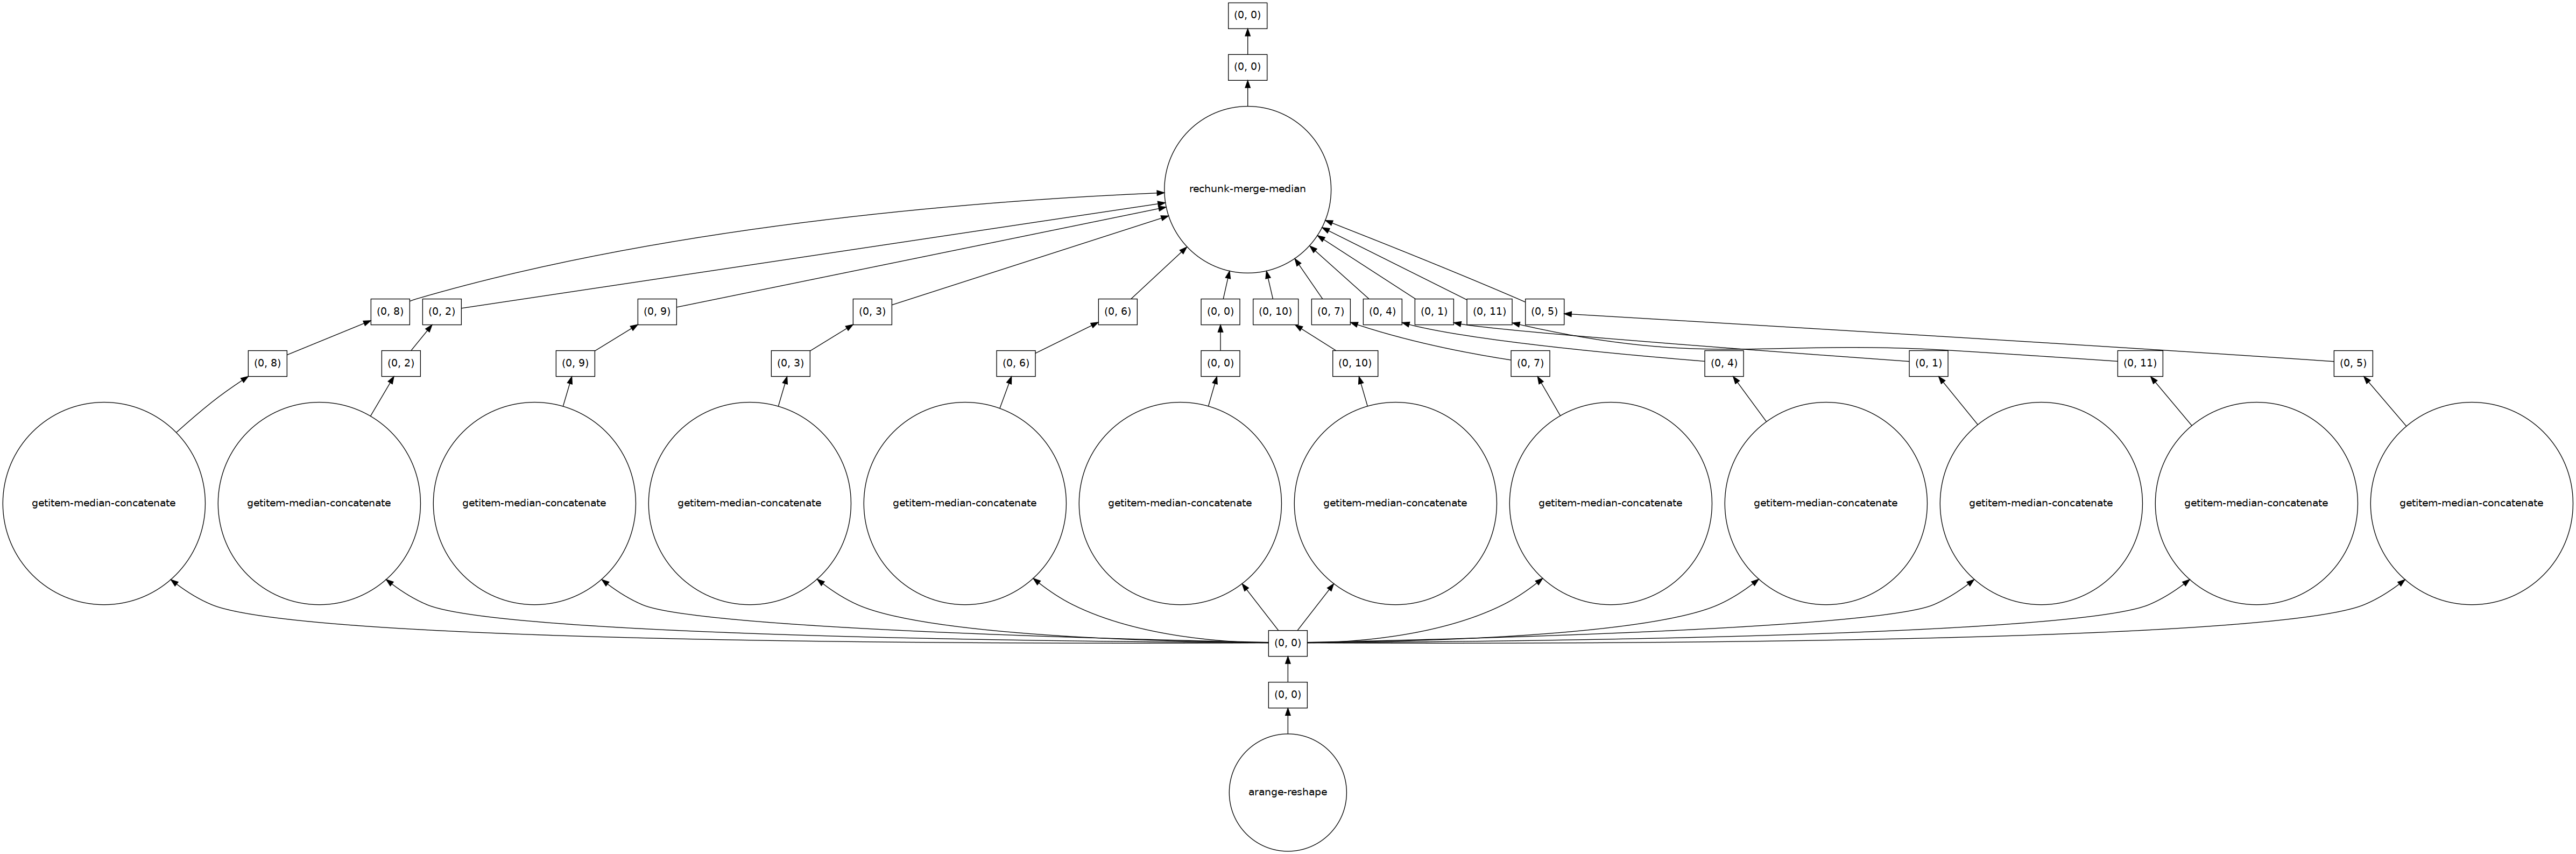

In [11]:
hm = HierarchicalMedian()
hm(da.arange(2600).reshape(20, 130)).visualize(optimize_graph=True)

In [12]:
import pycsou.util

timings = dict()
for xp in supported_array_modules():
    t1 = t.time()
    out = compute(hm.apply(xp.arange(2600).reshape(20, 130)))
    timings[xp.__name__] = t.time()-t1
print(timings)    

{'numpy': 0.0024390220642089844, 'cupy': 0.007131814956665039, 'dask.array': 0.01573467254638672}
